# Training the Score Function Estimator


In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

from score_po.dataset import Dataset
from score_po.score_matching import ScoreFunctionEstimator
from score_po.optimizer import OptimizerParams
from score_po.nn_architectures import MLP

from environment import Environment, plot_samples_and_enviroment

First, let's make a custom environment that we can use to draw data from. We will visualize the drawn points as well. 

Note here that we've normalized all our points to be in between -0.5 and 0.5. 
Empirically neural nets don't perform so well without this normalization.

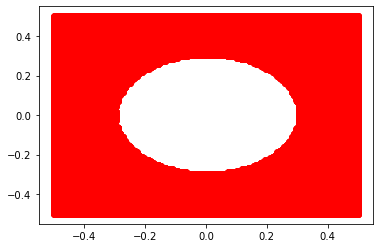

In [2]:
env = Environment()
env.generate_ellipse(39, 39, [64, 64])
pts = env.sample_points(500000) / 128 - 0.5

plt.figure()
plt.plot(pts[:, 0], pts[:, 1], "ro")
plt.show()

Now we will train a noise-conditioned score function estimator to try to estimate the gradient of this distribution, $s_\theta(z) = \nabla_z \log p(z)$. In order to do that we will need to define a neural network, a dataset object, and a scheduling of the variances.

First, the dataset and the NN can be defined using the following syntax.

In [3]:
dataset = Dataset(2, 0)
dataset.add_to_dataset(pts)
print(dataset.data.shape)

# Note that input is 3 because we need to include the parameter corresponding to network.
# The parameter values are taken from typical PPO network.
network = MLP(3, 2, [64, 64, 64, 64])

torch.Size([354700, 2])


Then, we can define a score function estimator and use it to train the network. When we're done, we'll save the weights.

100%|██████████| 1000/1000 [00:13<00:00, 72.43it/s]


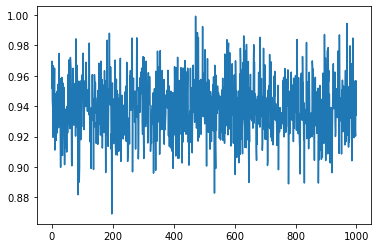

In [10]:
params = OptimizerParams()
params.batch_size = 512
params.iters = 1000
params.lr = 1e-3

sf = ScoreFunctionEstimator(network, 2, 0)
loss_lst = sf.train_network(dataset, params, 
                            sigma_max=1e-1, sigma_min=1e-1, n_sigmas=1)

plt.figure()
plt.plot(loss_lst)
plt.show()

sf.save_network_parameters("examples/light_dark/nn_weights.pth")


We can define a new instance and load the weights again to illustrate how to load files.

In [11]:
sf = ScoreFunctionEstimator(network, 2, 0)
sf.load_network_parameters("examples/light_dark/nn_weights.pth")

Now let's plot the gradients to see how we did! 

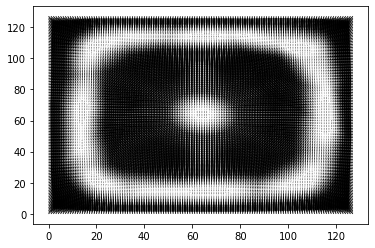

In [20]:
X, Y = np.meshgrid(range(128), range(128))
pos = np.vstack([X.ravel(), Y.ravel()]).T
pos = torch.Tensor(pos) / 128 - 0.5

grads = sf.get_score_z_given_z(pos, 0.1)
grads = grads.detach().numpy()
pos = pos.detach().numpy()

UV = np.swapaxes(grads, 0, 1).reshape(2, 128, 128)

plt.figure()
plt.quiver(X, Y, UV[0, :, :], UV[1, :, :], scale=400.0)
plt.show()
